
# 用N-Gram模型在莎士比亚文集中训练word embedding
N-gram 是计算机语言学和概率论范畴内的概念，是指给定的一段文本中N个项目的序列。
N=1 时 N-gram 又称为 unigram，N=2 称为 bigram，N=3 称为 trigram，以此类推。实际应用通常采用 bigram 和 trigram 进行计算。
本示例在莎士比亚文集上实现了trigram。

## 环境
本教程基于paddle-2.0-beta编写，如果您的环境不是本版本，请先安装paddle-2.0-beta。

In [1]:
import paddle
paddle.__version__

'2.0.0-beta0'

## 数据集&&相关参数
训练数据集采用了莎士比亚文集，[下载](https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt)，保存为txt格式即可。<br>
context_size设为2，意味着是trigram。embedding_dim设为256。

In [3]:
!wget https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt

--2020-09-12 13:49:29--  https://ocw.mit.edu/ans7870/6/6.006/s08/lecturenotes/files/t8.shakespeare.txt
正在连接 172.19.57.45:3128... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度：5458199 (5.2M) [text/plain]
正在保存至: “t8.shakespeare.txt”

t8.shakespeare.txt  100%[===================>]   5.21M  2.01MB/s  用时 2.6s      

2020-09-12 13:49:33 (2.01 MB/s) - 已保存 “t8.shakespeare.txt” [5458199/5458199])



In [4]:
embedding_dim = 256
context_size = 2

In [5]:
# 文件路径
path_to_file = './t8.shakespeare.txt'
test_sentence = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# 文本长度是指文本中的字符个数
print ('Length of text: {} characters'.format(len(test_sentence)))

Length of text: 5458199 characters


## 去除标点符号
因为标点符号本身无实际意义，用`string`库中的punctuation，完成英文符号的替换。

In [6]:
from string import punctuation
process_dicts={i:'' for i in punctuation}
print(process_dicts)

{'!': '', '"': '', '#': '', '$': '', '%': '', '&': '', "'": '', '(': '', ')': '', '*': '', '+': '', ',': '', '-': '', '.': '', '/': '', ':': '', ';': '', '<': '', '=': '', '>': '', '?': '', '@': '', '[': '', '\\': '', ']': '', '^': '', '_': '', '`': '', '{': '', '|': '', '}': '', '~': ''}


In [7]:
punc_table = str.maketrans(process_dicts)
test_sentence = test_sentence.translate(punc_table)
test_sentence = test_sentence.lower().split()
vocab = set(test_sentence)
print(len(vocab))

28343


## 数据预处理
将文本被拆成了元组的形式，格式为(('第一个词', '第二个词'), '第三个词');其中，第三个词就是我们的目标。

In [8]:
trigram = [[[test_sentence[i], test_sentence[i + 1]], test_sentence[i + 2]]
           for i in range(len(test_sentence) - 2)]

word_to_idx = {word: i for i, word in enumerate(vocab)}
idx_to_word = {word_to_idx[word]: word for word in word_to_idx}
# 看一下数据集
print(trigram[:3])

[[['this', 'is'], 'the'], [['is', 'the'], '100th'], [['the', '100th'], 'etext']]


## 构建`Dataset`类 加载数据
用`paddle.io.Dataset`构建数据集，然后作为参数传入到`paddle.io.DataLoader`，完成数据集的加载。

In [9]:
import paddle
import numpy as np
batch_size = 256
paddle.disable_static()
class TrainDataset(paddle.io.Dataset):
    def __init__(self, tuple_data):
        self.tuple_data = tuple_data

    def __getitem__(self, idx):
        data = self.tuple_data[idx][0]
        label = self.tuple_data[idx][1]
        data = np.array(list(map(lambda w: word_to_idx[w], data)))
        label = np.array(word_to_idx[label])
        return data, label
    
    def __len__(self):
        return len(self.tuple_data)
train_dataset = TrainDataset(trigram)
train_loader = paddle.io.DataLoader(train_dataset,places=paddle.CPUPlace(), return_list=True,
                                    shuffle=True, batch_size=batch_size, drop_last=True)

## 组网&训练
这里用paddle动态图的方式组网。为了构建Trigram模型，用一层 `Embedding` 与两层 `Linear` 完成构建。`Embedding` 层对输入的前两个单词embedding，然后输入到后面的两个`Linear`层中，完成特征提取。

In [30]:
import paddle
import numpy as np
import paddle.nn.functional as F
hidden_size = 1024
class NGramModel(paddle.nn.Layer):
    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramModel, self).__init__()
        self.embedding = paddle.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.linear1 = paddle.nn.Linear(context_size * embedding_dim, hidden_size)
        self.linear2 = paddle.nn.Linear(hidden_size, len(vocab))

    def forward(self, x):
        x = self.embedding(x)
        x = paddle.reshape(x, [-1, context_size * embedding_dim])
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x

## 定义`train()`函数，对模型进行训练。

In [31]:
import paddle.nn.functional as F
vocab_size = len(vocab)
epochs = 2
losses = []
def train(model):
    model.train()
    optim = paddle.optimizer.Adam(learning_rate=0.01, parameters=model.parameters())
    for epoch in range(epochs):
        for batch_id, data in enumerate(train_loader()):
            x_data = data[0]
            y_data = data[1]
            predicts = model(x_data)
            y_data = paddle.reshape(y_data, shape=[-1, 1])
            loss = F.softmax_with_cross_entropy(predicts, y_data)
            avg_loss = paddle.mean(loss)
            avg_loss.backward()
            if batch_id % 500 == 0:
                losses.append(avg_loss.numpy())
                print("epoch: {}, batch_id: {}, loss is: {}".format(epoch, batch_id, avg_loss.numpy())) 
            optim.step()
            optim.clear_grad()
model = NGramModel(vocab_size, embedding_dim, context_size)
train(model)

epoch: 0, batch_id: 0, loss is: [10.252176]
epoch: 0, batch_id: 500, loss is: [6.6429553]
epoch: 0, batch_id: 1000, loss is: [6.801544]
epoch: 0, batch_id: 1500, loss is: [6.7114644]
epoch: 0, batch_id: 2000, loss is: [6.628998]
epoch: 0, batch_id: 2500, loss is: [6.511376]
epoch: 0, batch_id: 3000, loss is: [6.878798]
epoch: 0, batch_id: 3500, loss is: [6.8752203]
epoch: 1, batch_id: 0, loss is: [6.5908413]
epoch: 1, batch_id: 500, loss is: [6.9765778]
epoch: 1, batch_id: 1000, loss is: [6.603841]
epoch: 1, batch_id: 1500, loss is: [6.9935036]
epoch: 1, batch_id: 2000, loss is: [6.751287]
epoch: 1, batch_id: 2500, loss is: [7.1222277]
epoch: 1, batch_id: 3000, loss is: [6.6431484]
epoch: 1, batch_id: 3500, loss is: [6.6024966]


## 打印loss下降曲线
通过可视化loss的曲线，可以看到模型训练的效果。

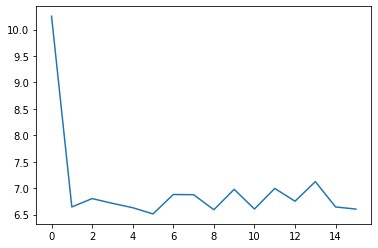

In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(losses)

## 预测
用训练好的模型进行预测。

In [36]:
import random
def test(model):
    model.eval()
    # 从最后10组数据中随机选取1个
    idx = random.randint(len(trigram)-10, len(trigram)-1)
    print('the input words is: ' + trigram[idx][0][0] + ', ' + trigram[idx][0][1])
    x_data = list(map(lambda w: word_to_idx[w], trigram[idx][0]))
    x_data = paddle.to_tensor(np.array(x_data))
    predicts = model(x_data)
    predicts = predicts.numpy().tolist()[0]
    predicts = predicts.index(max(predicts))
    print('the predict words is: ' + idx_to_word[predicts])
    y_data = trigram[idx][1]
    print('the true words is: ' + y_data)
test(model)

the input words is: of, william
the predict words is: shakespeare
the true words is: shakespeare
